# Reading and writing raster data

*veranda* offers specific classes allowing to read or write data both containing an internal file register (`file_register`). This register is in principle a table storing information about file paths (`'filepath'`), tile IDs/names (`'tile_id'`), and layer ID's (defaults to `'layer_id`), which represents the dimension to stack along and can be set by the user via the keyword `stack_dimension`, e.g. to create a temporal dimension. Slicing data in space or along the stack dimension is always performed without touching any data on disk, i.e. by solely using the spatial properties defined by a mosaic (see https://geospade.readthedocs.io/en/latest/notebooks/mosaic_geometry.html) or the file-based properties defined by `stack_dimension`. With this setup, the user should be able to select a region of interest, e.g. defined by a bounding box, polygon, coordinate tuple, etc., before reading or writing anything from or to disk, respectively. If data has already been read, then one is able to apply the same operations on the data in memory allowing transparent and granular access of raster data in space and along the stack dimension.   

## Writing GeoTIFF data

This section focuses on writing a stack of GeoTIFF files with the dedicated `GeoTiffWriter` class, before being able to read them with the `GeoTiffReader` class. First, we create our test dataset in memory, which should consist of two 3D NumPy arrays representing two bands. 

In [1]:
import numpy as np

num_files = 10
xsize = 60
ysize = 50
data_b1 = np.random.randn(num_files, ysize, xsize)
data_b2 = np.random.randn(num_files, ysize, xsize) * 2

As an example, we want the data to be defined in the LatLon projection. To attach the relevant geospatial context to the existing, plain NumPy array we can create a tile object with `geospade`

In [2]:
from geospade.crs import SpatialRef
from geospade.raster import Tile

ds_tile = Tile(ysize, xsize, SpatialRef(4326), name='my_tile')

and store the data in an xarray dataset with the dimensions time (`'time'`), latitude (`'lat'`), and longitude (`'lon'`).

In [3]:
import pandas as pd
import xarray as xr

dims = ['time', 'lat', 'lon']
band_names = ['band_1', 'band_2']
coords = {'time': pd.date_range('2000-01-01', periods=num_files),
          'lat': ds_tile.y_coords,
          'lon': ds_tile.x_coords}

ds = xr.Dataset({band_names[0]: (dims, data_b1), band_names[1]: (dims, data_b2)}, coords=coords)

It should be emphasized here that an xarray dataset is the central unit to which data read from disk is converted to, or data is expected to be when writing it to disk, since its structure allows to store essential metadata information next to the actual data, e.g. coordinates, spatial reference information, or metadata attributes.

The tile we have created before can now be used to initialise a generic mosaic, which is a required argument for the constructor of `GeoTiffWriter`. 

In [4]:
from geospade.raster import MosaicGeometry

ds_mosaic = MosaicGeometry.from_tile_list([ds_tile])

Optionally, i.e. if not already provided via a pandas dataframe representing the file register, we can specify where we want to store the data (`dirpath`), how the file name should be build (`fn_pattern`), and how coordinates along the file dimensions can be encoded as strings. In this case we create a temporary directory and aim to have the timestamp in the file name.

In [5]:
from tempfile import mkdtemp

dst_dirpath = mkdtemp()
fn_pattern = '{time}.tif'
fn_formatter = {'time': lambda x: x.strftime('%Y%m%d')}

Now we have everything to generate an instance of the `GeoTiffWriter` class.

In [6]:
from veranda.raster.mosaic.geotiff import GeoTiffWriter

gt_writer =  GeoTiffWriter(ds_mosaic, data=ds, stack_dimension='time', dirpath=dst_dirpath, fn_pattern=fn_pattern, 
                           fn_formatter=fn_formatter)
gt_writer

,time,tile_id,filepath
0,2000-01-01 00:00:00,my_tile,C:\Users\cnavacch\AppData\Local\Temp\tmpm89icqxy\20000101.tif
1,2000-01-02 00:00:00,my_tile,C:\Users\cnavacch\AppData\Local\Temp\tmpm89icqxy\20000102.tif
2,2000-01-03 00:00:00,my_tile,C:\Users\cnavacch\AppData\Local\Temp\tmpm89icqxy\20000103.tif
3,2000-01-04 00:00:00,my_tile,C:\Users\cnavacch\AppData\Local\Temp\tmpm89icqxy\20000104.tif
4,2000-01-05 00:00:00,my_tile,C:\Users\cnavacch\AppData\Local\Temp\tmpm89icqxy\20000105.tif
5,2000-01-06 00:00:00,my_tile,C:\Users\cnavacch\AppData\Local\Temp\tmpm89icqxy\20000106.tif
6,2000-01-07 00:00:00,my_tile,C:\Users\cnavacch\AppData\Local\Temp\tmpm89icqxy\20000107.tif
7,2000-01-08 00:00:00,my_tile,C:\Users\cnavacch\AppData\Local\Temp\tmpm89icqxy\20000108.tif
8,2000-01-09 00:00:00,my_tile,C:\Users\cnavacch\AppData\Local\Temp\tmpm89icqxy\20000109.tif
9,2000-01-10 00:00:00,my_tile,C:\Users\cnavacch\AppData\Local\Temp\tmpm89icqxy\20000110.tif


The file register above now provides the necessary insights how the xarray dataset stacked along `'time'` relates to files on disk. Note that this instance automatically opens pointers to the files when calling the `write` function. Thus, to properly close them, you either need to call the `close()` method or you directly create the instance in the context of the `with` statement.  

### Plotting the mosaic

To get a feeling about the spatial coverage of the data, one can call the `plot()` function of the mosaic. Here we add a little buffer of 10 degree around the tile 'my_tile'.

<GeoAxesSubplot:>

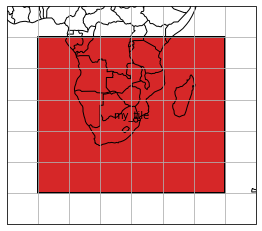

In [7]:
extent = np.array(gt_writer.mosaic.outer_extent)
extent += np.array([-10, -10, 10, 10])
gt_writer.mosaic.plot(extent=extent, label_tiles=True)

### Selecting a bounding box

If we are interested in a specific region of interest, e.g. Madagaskar, we can subset the data and mosaic by calling the `select_bbox` function with a bounding box defining the data extent we want to have. Note that all `select_...` methods have a keyword `inplace`, which defines if the data writer or reader instance should be modified in place, or if a new object should be returned.

<GeoAxesSubplot:>

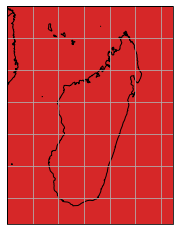

In [8]:
gt_writer.select_bbox([40, -27, 53, -10], inplace=True)
gt_writer.mosaic.plot(extent=gt_writer.mosaic.outer_extent)

### Inspecting raw data array
You can always inspect the current state of the data by making use of the `data_view` property. 

In [9]:
gt_writer.data_view

<xarray.Dataset>
Dimensions:  (time: 10, lat: 17, lon: 13)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-05 2000-01-10 ... 2000-01-06
  * lat      (lat) float64 -10.0 -11.0 -12.0 -13.0 ... -23.0 -24.0 -25.0 -26.0
  * lon      (lon) float64 40.0 41.0 42.0 43.0 44.0 ... 48.0 49.0 50.0 51.0 52.0
Data variables:
    band_1   (time, lat, lon) float64 -0.2425 -0.4216 2.058 ... -0.6761 -0.2067
    band_2   (time, lat, lon) float64 0.8727 -1.305 0.4606 ... -0.8868 1.19

Taking a look at the spatial dimensions shows that the xarray dataset has been sliced according to the new area of interest. Since we are now happy with this state, we can write our spatio-temporal, multi-band data to disk. 

### Serializing raster data
Writer classes in *veranda* provide two methods to achieve this, a `write()` and an `export()` method. The former should be used if you want to stream data to disk, because it might be too large to fit into memory, thus it can't be written once. It accepts an xarray dataset as an argument instead of using the internal one (if it exists). Here, we do not have such an issue and can therefore dump all data to disk in one run by calling `export()`.

In [10]:
gt_writer.export()

Inspecting the content of the output directory shows all files that have been created.

In [11]:
import os
os.listdir(dst_dirpath)

['20000101.tif',
 '20000102.tif',
 '20000103.tif',
 '20000104.tif',
 '20000105.tif',
 '20000106.tif',
 '20000107.tif',
 '20000108.tif',
 '20000109.tif',
 '20000110.tif']

As mentioned before, as soon as one does not need the writer or reader object anymore, one can call `close()` to properly remove and close all open links to files.  

In [12]:
gt_writer.close()

## Reading GeoTIFF data

Now we have some GeoTIFF files available on disk, so we can try to read them by using *verandas* `GeoTiffReader` class. This class has a handy classmethod called `from_filepaths()`, which creates a file register containing one stack of files. If your files are distributed across more than one tile, than you can use the classmethod `from_mosaic_filepaths()`, which checks the spatial reference of each file and aligns them accordingly in space using a generic mosaic by default. In our case we know that we only have one stack of files and can therefore initialise a `GeoTiffReader` object using a list of file paths retrieved from the previous `GeoTiffWriter` instance.

In [13]:
from veranda.raster.mosaic.geotiff import GeoTiffReader
filepaths = sorted(list(gt_writer.filepaths))
gt_reader = GeoTiffReader.from_filepaths(filepaths)
gt_reader

,filepath,tile_id,layer_id
0,C:\Users\cnavacch\AppData\Local\Temp\tmpm89icqxy\20000101.tif,0,1
1,C:\Users\cnavacch\AppData\Local\Temp\tmpm89icqxy\20000102.tif,0,2
2,C:\Users\cnavacch\AppData\Local\Temp\tmpm89icqxy\20000103.tif,0,3
3,C:\Users\cnavacch\AppData\Local\Temp\tmpm89icqxy\20000104.tif,0,4
4,C:\Users\cnavacch\AppData\Local\Temp\tmpm89icqxy\20000105.tif,0,5
5,C:\Users\cnavacch\AppData\Local\Temp\tmpm89icqxy\20000106.tif,0,6
6,C:\Users\cnavacch\AppData\Local\Temp\tmpm89icqxy\20000107.tif,0,7
7,C:\Users\cnavacch\AppData\Local\Temp\tmpm89icqxy\20000108.tif,0,8
8,C:\Users\cnavacch\AppData\Local\Temp\tmpm89icqxy\20000109.tif,0,9
9,C:\Users\cnavacch\AppData\Local\Temp\tmpm89icqxy\20000110.tif,0,10


Our stack dimension now contains integer values and is called `'layer_id'` instead of `'time'`, since `from_filepaths()` simply assigns integer coordinates to files depending on their order in the file list. The same holds true for the tile ID, which is by default `'0'`.

### Select a window in pixels

Same as before we wrote the dataset to disk, we further shrink our area of interest, but this time we use `select_px_window()`, which requires a pixel window as input, defined by the row and column coordinates of the upper-left anchor point and the width and height of the window.

In [14]:
dc_reader = gt_reader.select_px_window(7, 3, width=10, height=10, inplace=False)

### Reading the actual data


`dc_reader` is the final reader object defining the spatial and stack extent we want to read. To do so, we need to call the `read()` method and adjust some keywords, i.e. we want to assign the same name to the bands stored in the GeoTIFF files as we defined it before writing them to disk. Moreover, we choose the engine `'vrt'`, which creates a GDAL VRT stack from the given files. As a second option for `engine` you can select `'parallel'` for reading each file in a parallel manner, which can be steered with the keyword `n_cores`. If files are located on a single disk, `'vrt'` should be faster than `'parallel'`, whereas on a parallel file system `'parallel'` should significantly speed up the reading time.   

In [15]:
dc_reader.read(bands=[1, 2], band_names=band_names, engine='vrt', n_cores=1)
dc_reader.data_view

<xarray.Dataset>
Dimensions:      (layer_id: 10, y: 10, x: 10)
Coordinates:
  * layer_id     (layer_id) int32 1 2 3 4 5 6 7 8 9 10
  * y            (y) float64 -17.0 -18.0 -19.0 -20.0 ... -23.0 -24.0 -25.0 -26.0
  * x            (x) float64 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0
    spatial_ref  int32 0
Data variables:
    band_1       (layer_id, y, x) float64 -0.4861 -1.803 ... 0.009609 0.01689
    band_2       (layer_id, y, x) float64 1.677 1.131 0.7566 ... -1.354 0.02766

### Select time series

As an example, we can further select a time series from the loaded dataset by calling the `select.xy()` method. 

In [16]:
ts_reader = dc_reader.select_xy(49, -20)
ts_reader.data_view

<xarray.Dataset>
Dimensions:      (layer_id: 10, y: 1, x: 1)
Coordinates:
  * layer_id     (layer_id) int32 1 2 3 4 5 6 7 8 9 10
  * y            (y) float64 -20.0
  * x            (x) float64 49.0
    spatial_ref  int32 0
Data variables:
    band_1       (layer_id, y, x) float64 -0.5803 1.461 ... -0.6012 -0.5499
    band_2       (layer_id, y, x) float64 -0.6958 -3.779 ... -2.062 -3.375

## Writing NetCDF data

NetCDF data reading and writing can be performed in the same manner as with GeoTIFF data, except some differences in the naming, e.g. `'data_variables'` instead of `'bands'`, and variety of methods. In this section we want to demonstrate another use case, namely how one can write data to a (regular) mosaic instead of a single tile. To do so, we first need to create a definition of the target mosaic, which is for instance possible via `geospade`'s `RegularMosaicGeometry` class. Using its classmethod `from_rectangular_definition()`, we can specify the shape of the mosaic and how large the tiles should be. In the example below, we split our initial data extent into 4 tiles.

<GeoAxesSubplot:>

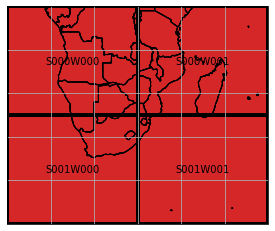

In [17]:
from geospade.raster import RegularMosaicGeometry
mosaic_rows, mosaic_cols = 2, 2
x_tile_size, y_tile_size = 30, 25
ds_mosaic = RegularMosaicGeometry.from_rectangular_definition(mosaic_rows, mosaic_cols, x_tile_size, y_tile_size, ds_tile.sref, geotrans=ds_tile.geotrans)
ds_mosaic.plot(extent=ds_mosaic.outer_extent, label_tiles=True, edgewidth=4)

Before we pass this new mosaic definition to the `NetCdfWriter` constructor, we need to allocate some additional keyword arguments and reset the output directory path. To achieve a unique naming , we also need to add the `'tile_id'` to the file name pattern.

In [18]:
dst_dirpath = mkdtemp()
fn_pattern='{time}_{tile_id}.nc'
fn_formatter={'time': lambda x: x.strftime('%Y%m%d')}

Now `NetCdfWriter` can be instantiated in the same manner as `GeoTiffWriter`.

In [19]:
from veranda.raster.mosaic.netcdf import NetCdfWriter

nc_writer =  NetCdfWriter(ds_mosaic, data=ds, stack_dimension='time', dirpath=dst_dirpath, fn_pattern=fn_pattern, 
                           fn_formatter=fn_formatter)
nc_writer

,time,tile_id,filepath
0,2000-01-01 00:00:00,S000W000,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000101_S000W000.nc
1,2000-01-01 00:00:00,S000W001,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000101_S000W001.nc
2,2000-01-01 00:00:00,S001W000,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000101_S001W000.nc
3,2000-01-01 00:00:00,S001W001,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000101_S001W001.nc
4,2000-01-02 00:00:00,S000W000,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000102_S000W000.nc
5,2000-01-02 00:00:00,S000W001,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000102_S000W001.nc
6,2000-01-02 00:00:00,S001W000,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000102_S001W000.nc
7,2000-01-02 00:00:00,S001W001,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000102_S001W001.nc
8,2000-01-03 00:00:00,S000W000,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000103_S000W000.nc
9,2000-01-03 00:00:00,S000W001,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000103_S000W001.nc


### Selecting layers

If we want to subset along the stack dimension, we can do this via `select_layers()`.

In [20]:
nc_writer.select_layers(pd.date_range('2000-01-01', '2000-01-05'), inplace=True)

,time,tile_id,filepath
0,2000-01-01 00:00:00,S000W000,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000101_S000W000.nc
1,2000-01-01 00:00:00,S000W001,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000101_S000W001.nc
2,2000-01-01 00:00:00,S001W000,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000101_S001W000.nc
3,2000-01-01 00:00:00,S001W001,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000101_S001W001.nc
4,2000-01-02 00:00:00,S000W000,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000102_S000W000.nc
5,2000-01-02 00:00:00,S000W001,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000102_S000W001.nc
6,2000-01-02 00:00:00,S001W000,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000102_S001W000.nc
7,2000-01-02 00:00:00,S001W001,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000102_S001W001.nc
8,2000-01-03 00:00:00,S000W000,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000103_S000W000.nc
9,2000-01-03 00:00:00,S000W001,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000103_S000W001.nc


### Export to NetCDF

Now everything is ready to be written to disk. Again, we want to export all of the data at once, thus we use `export()`, and specify that we want to tile the data according to our new mosaic defintion with `apply_tiling=True`.

In [21]:
nc_writer.export(apply_tiling=True)

If we check the output directory again, we can see that five NetCDF files for each of the four tiles have been created.

In [22]:
os.listdir(dst_dirpath)

['20000101_S000W000.nc',
 '20000101_S000W001.nc',
 '20000101_S001W000.nc',
 '20000101_S001W001.nc',
 '20000102_S000W000.nc',
 '20000102_S000W001.nc',
 '20000102_S001W000.nc',
 '20000102_S001W001.nc',
 '20000103_S000W000.nc',
 '20000103_S000W001.nc',
 '20000103_S001W000.nc',
 '20000103_S001W001.nc',
 '20000104_S000W000.nc',
 '20000104_S000W001.nc',
 '20000104_S001W000.nc',
 '20000104_S001W001.nc',
 '20000105_S000W000.nc',
 '20000105_S000W001.nc',
 '20000105_S001W000.nc',
 '20000105_S001W001.nc']

Finally, we need to close the writer object.

In [23]:
nc_writer.close()

## Reading NetCDF data

If we want to read our generated dataset again, we can use the class `NetCdfReader` and initialise it with the file register from the NetCDF writer instance and the original mosaic consisting of four tiles.

In [24]:
from veranda.raster.mosaic.netcdf import NetCdfReader

nc_reader = NetCdfReader(nc_writer.file_register, ds_mosaic, stack_dimension='time')
nc_reader

,time,tile_id,filepath
0,2000-01-01 00:00:00,S000W000,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000101_S000W000.nc
1,2000-01-01 00:00:00,S000W001,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000101_S000W001.nc
2,2000-01-01 00:00:00,S001W000,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000101_S001W000.nc
3,2000-01-01 00:00:00,S001W001,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000101_S001W001.nc
4,2000-01-02 00:00:00,S000W000,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000102_S000W000.nc
5,2000-01-02 00:00:00,S000W001,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000102_S000W001.nc
6,2000-01-02 00:00:00,S001W000,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000102_S001W000.nc
7,2000-01-02 00:00:00,S001W001,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000102_S001W001.nc
8,2000-01-03 00:00:00,S000W000,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000103_S000W000.nc
9,2000-01-03 00:00:00,S000W001,C:\Users\cnavacch\AppData\Local\Temp\tmp_i1o9xpg\20000103_S000W001.nc


From this dataset, we are now interested in a region intersecting with all four tiles in the centre. 

<GeoAxesSubplot:>

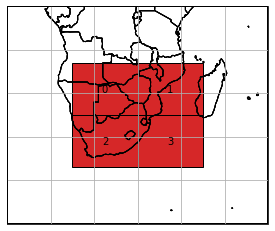

In [25]:
nc_reader.select_bbox([15, -37, 45, -13], inplace=True)
nc_reader.mosaic.plot(extent=ds_mosaic.outer_extent, label_tiles=True)

### Reading tiled dataset from NetCDF

The reader classes are able to stitch the tiled dataset together to retrieve one stack of data. To read the data, we can use `read()` and select `'netcdf4'` from the available set of engines, i.e. `'netcdf4'` directly uses Python's netCDF4 library or `'xarray'` offering more flexibility, but less performance.

In [26]:
nc_reader.read(engine='netcdf4')
nc_reader.data_view

<xarray.Dataset>
Dimensions:      (time: 5, lat: 24, lon: 30)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-05 2000-01-01 ... 2000-01-04
  * lat          (lat) float64 -13.0 -14.0 -15.0 -16.0 ... -34.0 -35.0 -36.0
  * lon          (lon) float64 15.0 16.0 17.0 18.0 19.0 ... 41.0 42.0 43.0 44.0
    spatial_ref  int32 0
Data variables:
    band_1       (time, lat, lon) float64 0.06199 -0.6701 ... -2.768 0.3493
    band_2       (time, lat, lon) float64 -0.4928 0.55 2.973 ... 0.2385 -2.775

## Writing NetCDF data (single stack)

Finally, the data we have just loaded into memory can again be very simply dumped to disk in one piece. `NetCdfWriter` provides the classmethod `from_data()`, which creates an instance from an xarray dataset and one target file path.

In [27]:
dst_dirpath = mkdtemp()
dst_filepath = os.path.join(dst_dirpath, "test_file.nc")

This time we use the `with` statement to simplify opening and closing of I/O pointers.

In [28]:
with NetCdfWriter.from_data(nc_reader.data_view, dst_filepath, stack_dimension='time') as nc_writer:
    nc_writer.export()
nc_writer

,tile_id,filepath,time
0,0,C:\Users\cnavacch\AppData\Local\Temp\tmp6nc__2gc\test_file.nc,2000-01-05 00:00:00
1,0,C:\Users\cnavacch\AppData\Local\Temp\tmp6nc__2gc\test_file.nc,2000-01-01 00:00:00
2,0,C:\Users\cnavacch\AppData\Local\Temp\tmp6nc__2gc\test_file.nc,2000-01-03 00:00:00
3,0,C:\Users\cnavacch\AppData\Local\Temp\tmp6nc__2gc\test_file.nc,2000-01-02 00:00:00
4,0,C:\Users\cnavacch\AppData\Local\Temp\tmp6nc__2gc\test_file.nc,2000-01-04 00:00:00


The NetCDF reader instance was still kept open to pass data to the NetCDF writer class, but now it can be closed.

In [29]:
nc_reader.close()

Checking our output directy reveals that one NetCDF file, which contains data within the bounding box intersecting with all four tiles, has been generated.

In [30]:
os.listdir(dst_dirpath)

['test_file.nc']